Run ID 241209TF
EXP ID EXP_H_240118_CV1_A1
running getData
C:\Users\jonny\Lehigh University Dropbox\ENG-MATSGroup\MATS\cRIO\RunConfig\EXPs\\EXP_H_240118_CV1_A1.csv
TC Positions (raw):
0     246.0
1     195.0
2     195.0
3     157.0
4     157.0
5     157.0
6     120.0
7     120.0
8      69.0
9       NaN
10      NaN
Name: X Position, dtype: float64
TC_positions (valid & sorted):
8     69
6    120
7    120
3    157
4    157
5    157
1    195
2    195
0    246
Name: X Position, dtype: int64
TC_df (valid TCs):
  Device Type NI LV Channel    Shorthand Tag  X Position
8          TC      CV1-TC38    T1-TC-69(180)          69
6          TC      CV1-TC48     T1-TC-120(0)         120
7          TC      CV1-TC36   T1-TC-120(180)         120
3          TC      CV1-TC47     T1-TC-157(0)         157
4          TC      CV1-TC34  T1-TC-157(180)*         157
5          TC      CV1-TC34  T1-TC-157(180)*         157
1          TC      CV1-TC46     T1-TC-195(0)         195
2          TC      CV1-TC32   T1-

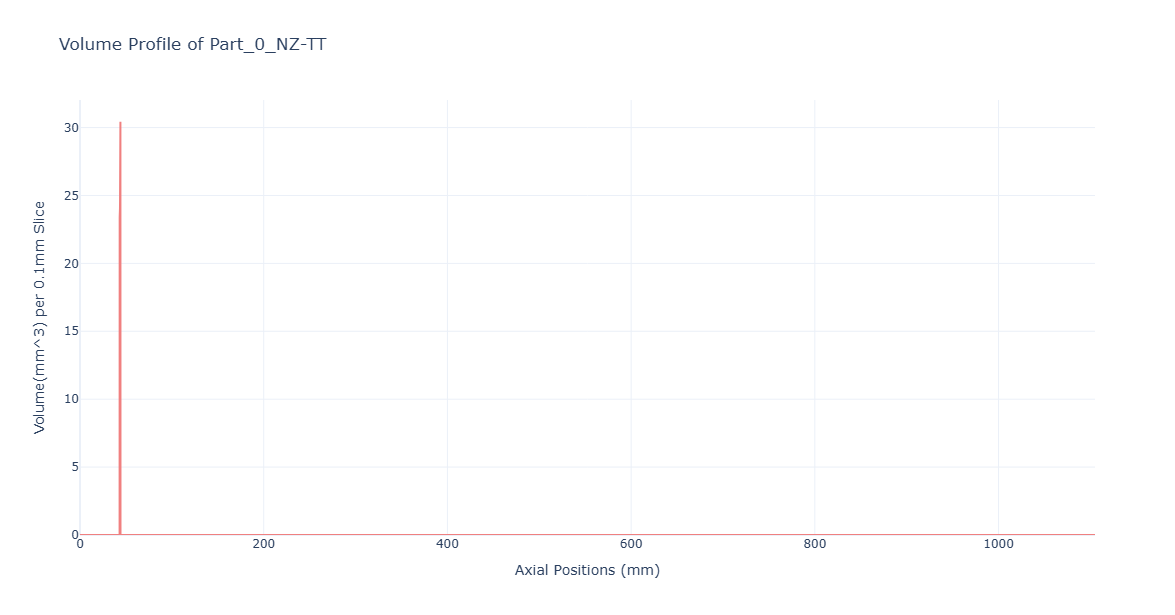

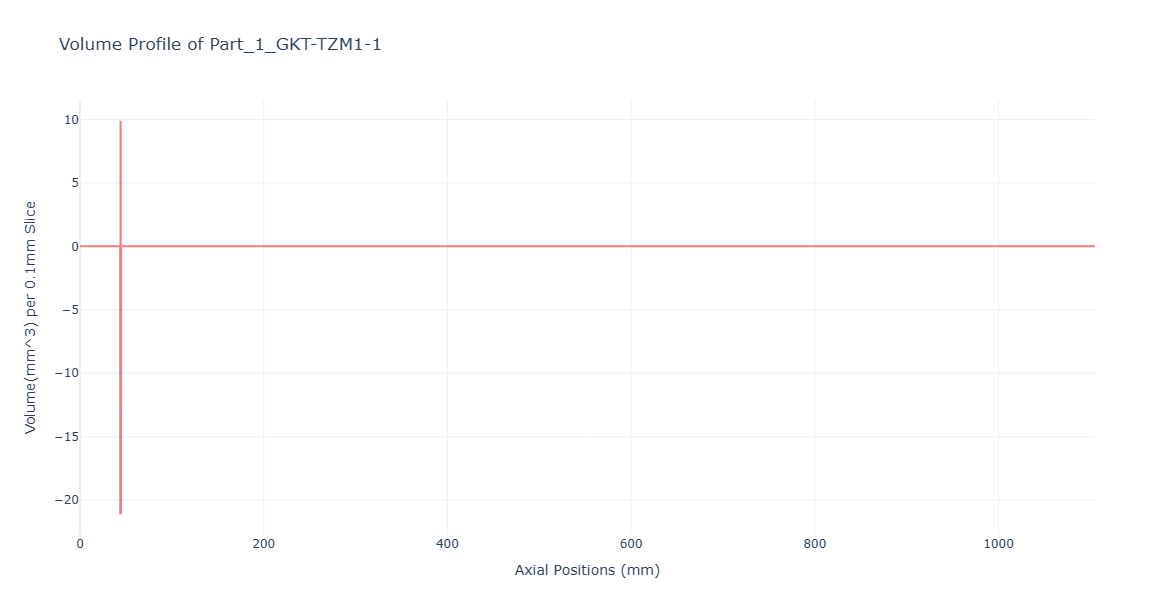

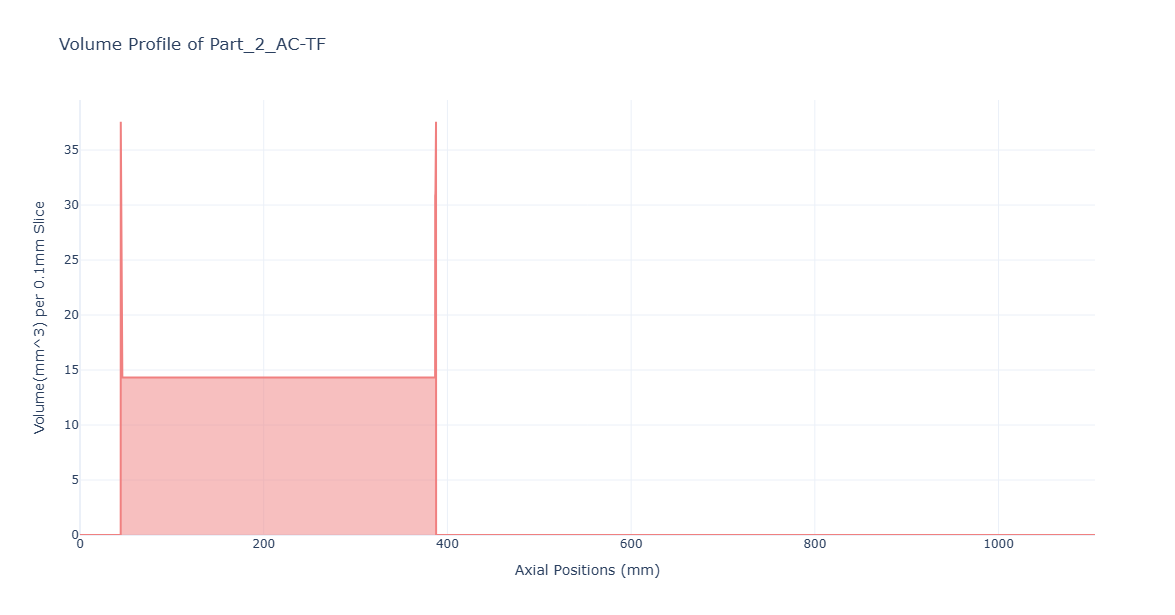

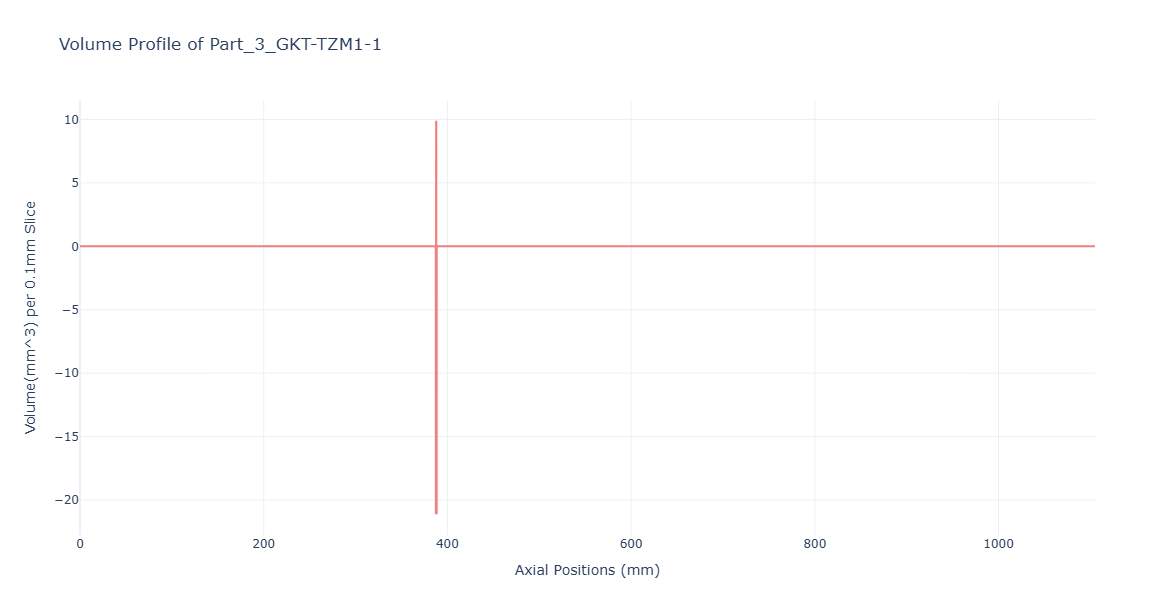

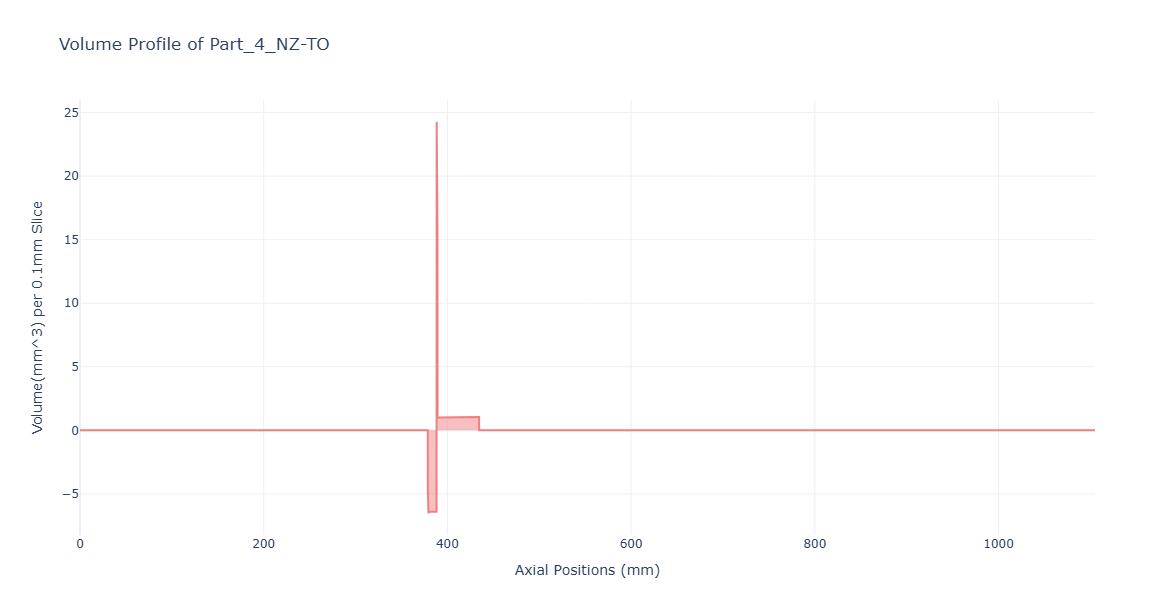

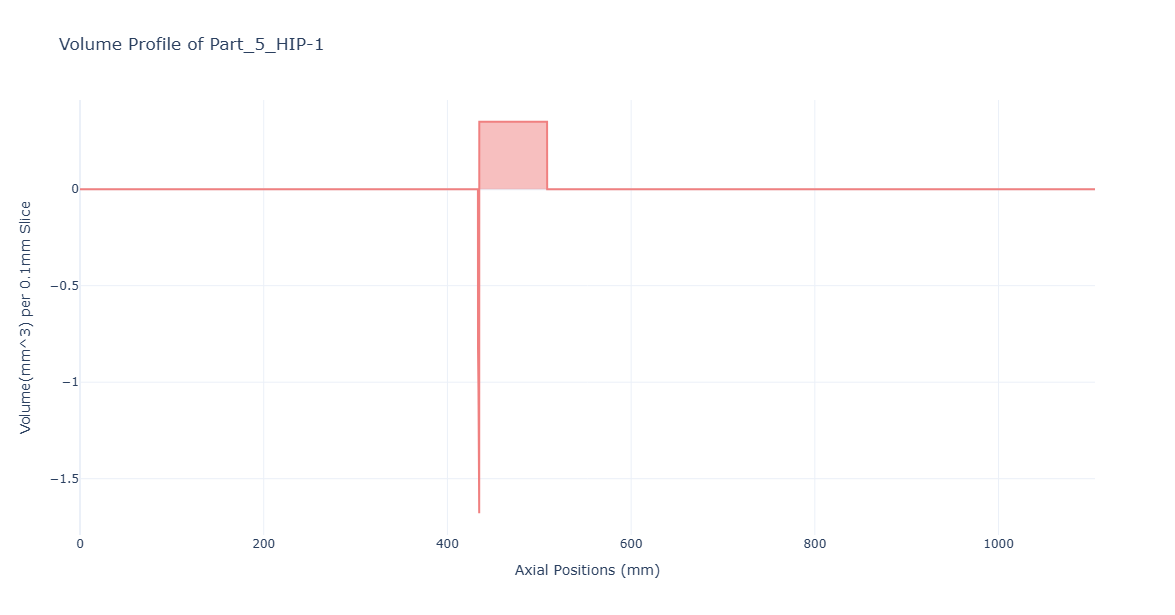

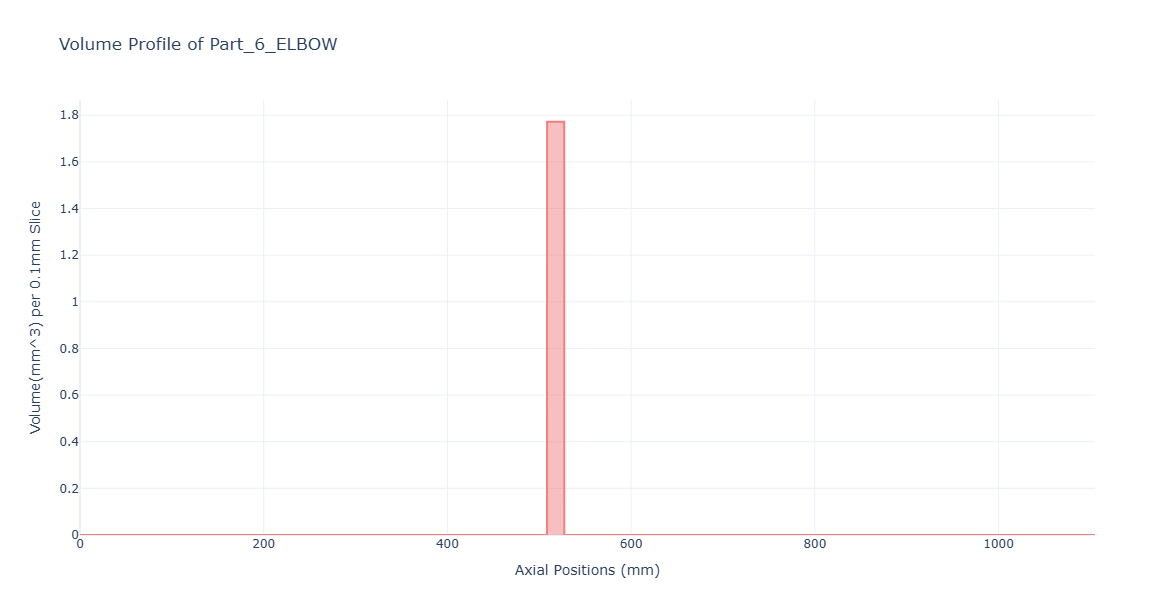

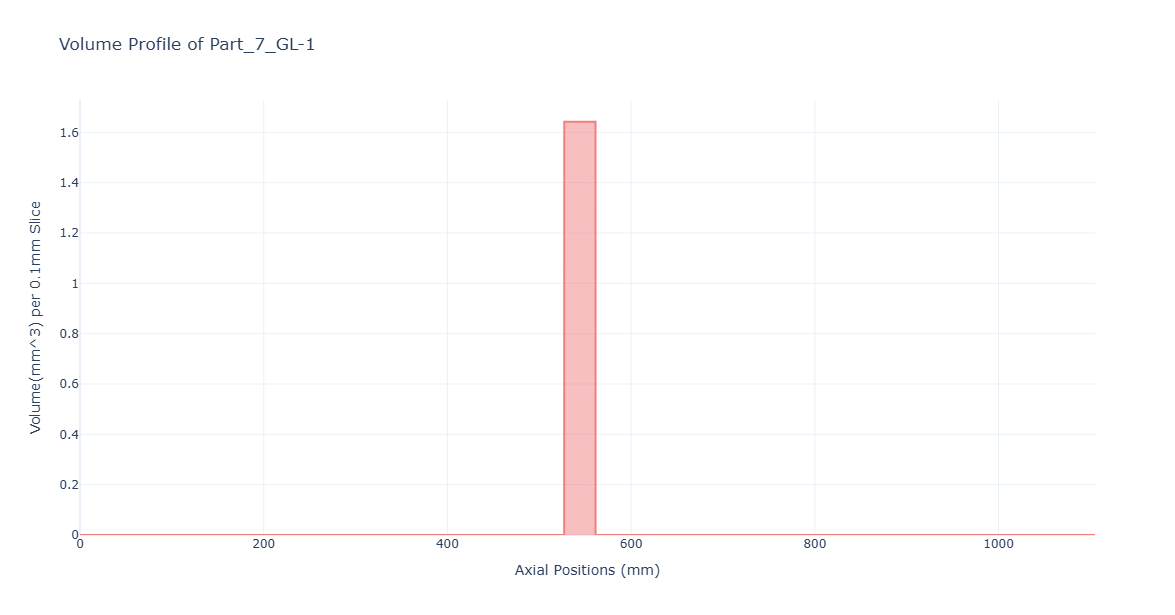

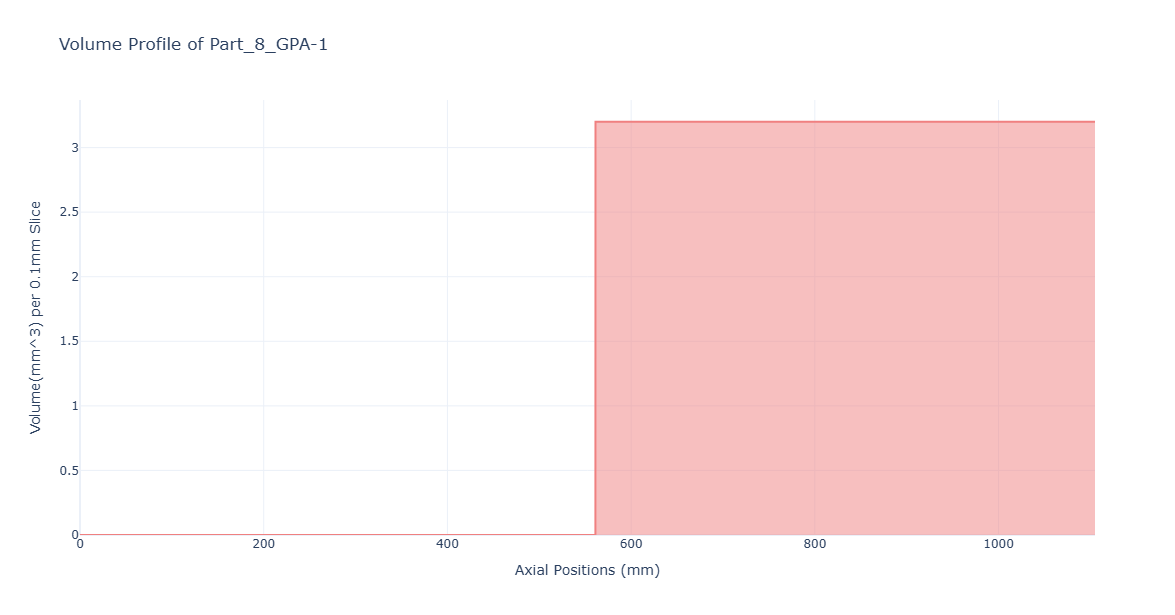

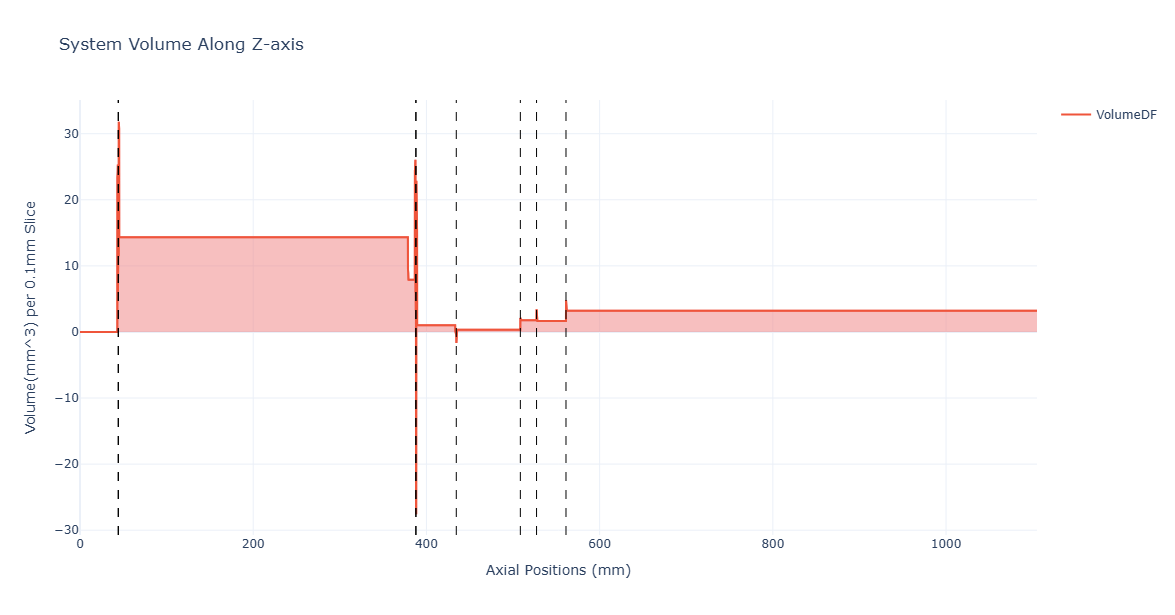



Total System Volume from VolumeDF (mL): 68.05263124422471
Total System Volume from CoarseVol (mL): 68.05263124422473


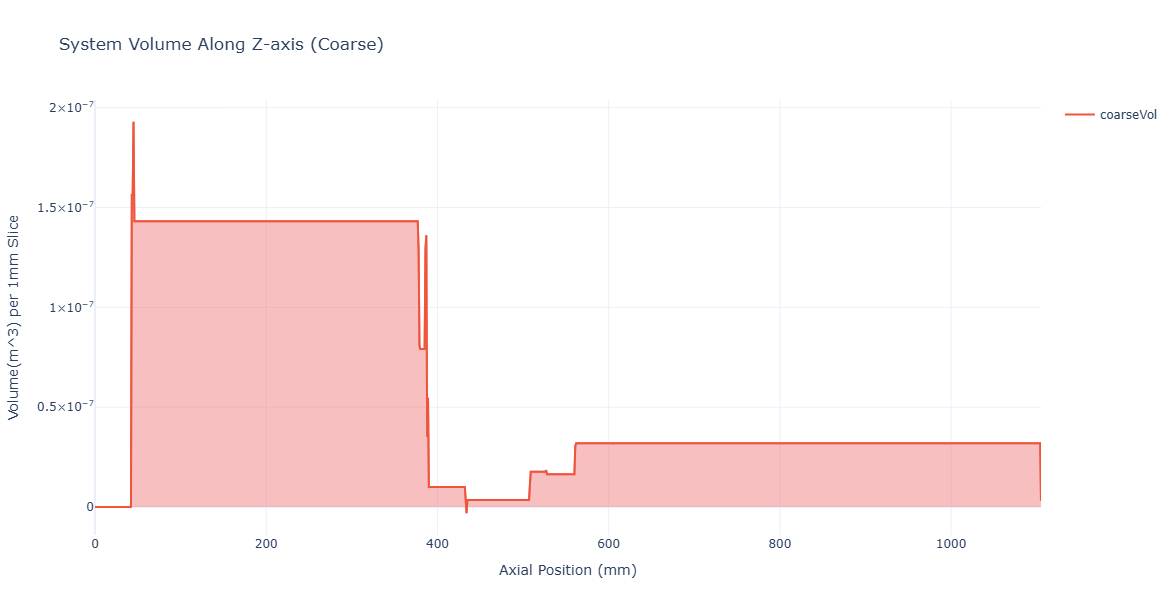

Temperature calibration range: 1 mm to 313 mm
runtempsDF:
runTempsDF length = 64688
P_Pa length = 64688
z_list_str:
0.0
0.2776166666666667
0.5553833333333333
0.83315
1.1109333333333333
1.3887166666666666
1.6664833333333333
1.94425
2.222
2.4997666666666665
2.777533333333333
3.0553166666666667
3.3330833333333336
3.6108666666666664
3.8886499999999997
4.166433333333333
4.4441999999999995
4.721983333333333
4.999766666666667
5.277533333333333
5.555866666666666
5.835033333333333
6.114199999999999
6.393083333333333
6.67225
6.951416666666666
7.230033333333334
7.50865
7.787816666666667
8.0667
8.345583333333334
8.624483333333334
8.90365
9.182816666666668
9.461983333333334
9.740866666666667
10.019483333333334
10.298083333333333
10.57725
10.856150000000001
11.135033333333332
11.413916666666667
11.693366666666666
11.97225
12.2517
12.530583333333334
12.809750000000001
13.088916666666668
13.367816666666666
13.646983333333333
13.92615
14.205033333333335
14.483916666666666
14.763083333333332
15.04198333

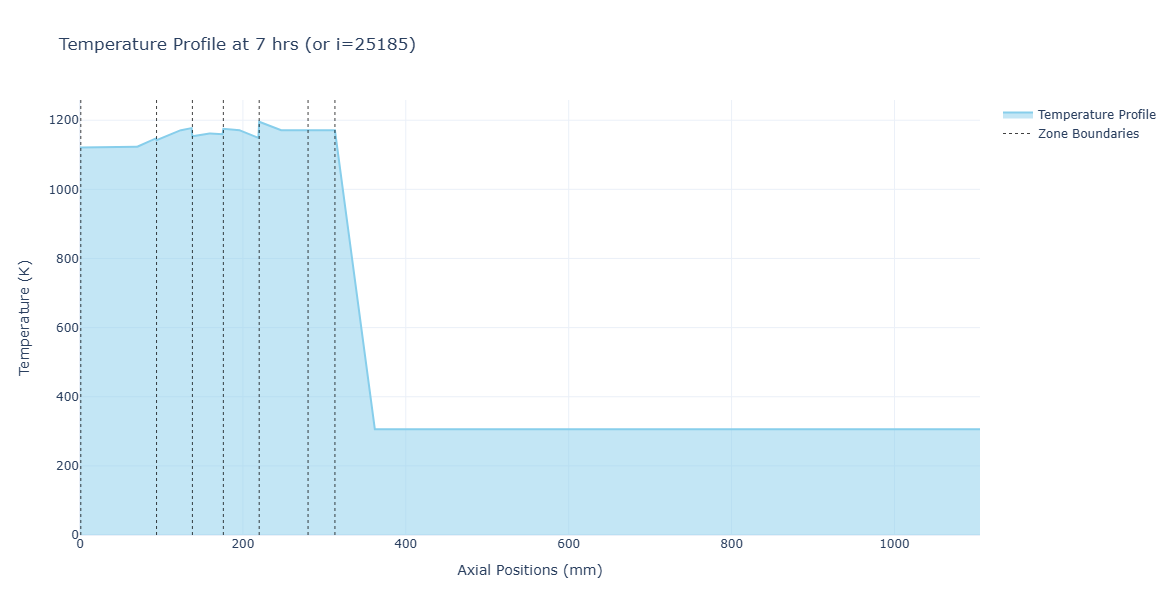

In [ ]:
# Clears out any variables, just to be safe.
%reset -f

import tkinter as tk
from tkinter import *
from tkinter import ttk
from tkinter import filedialog
from tkinter.ttk import Progressbar
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import plotly.graph_objects as go
import numpy as np
import math
import os
import re
import sys
import json
import ast
from time import perf_counter
from time import perf_counter_ns
import seaborn as sns

# --- Global variables for file paths ---
data_filename = ""
temp_profile_file = ""
layout_file = ""
mating_table_file = ""
fur_file = ""
hps_file = ""
runData = []
runBool = False
imageViewer = None
baselineEdited = False
z_temp_cutoff_var = None
z_offset_var = None

# --- browseFiles function ---
def browseFiles():
    global data_filename, temp_profile_file, layout_file, mating_table_file, fur_file, hps_file

    data_filename = filedialog.askopenfilename(
        initialdir=os.path.expanduser('~\\Lehigh University Dropbox'),
        title="1. Select Data CSV File",
        filetypes=(("CSV files", "*.csv*"), ("all files", "*.*"))
    )
    if data_filename:
        fileLabel.configure(text=f"Data File: {os.path.basename(data_filename)}")
    else:
        fileLabel.configure(text="Data File: (Not Selected)")

    start_dir = os.path.dirname(data_filename) if data_filename else os.path.expanduser('~')

    temp_profile_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="2. Select Temperature Profile CSV File (e.g., ...TempCal.csv)",
        filetypes=(("CSV files", "*.csv*"), ("all files", "*.*"))
    )
    if temp_profile_file:
        tempLabel.configure(text=f"Temp Profile: {os.path.basename(temp_profile_file)}")
    else:
        tempLabel.configure(text="Temperature Profile: (Not Selected)")

    layout_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="3. Select Autoclave Layout File (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if layout_file:
        layoutLabel.configure(text=f"Layout File: {os.path.basename(layout_file)}")
    else:
        layoutLabel.configure(text="Layout File: (Not Selected)")

    mating_table_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="4. Select Surface Mating Table (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if mating_table_file:
        matingLabel.configure(text=f"Mating Table: {os.path.basename(mating_table_file)}")
    else:
        matingLabel.configure(text="Mating Table: (Not Selected)")

    fur_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="5. Select MLD - FUR File (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if fur_file:
        furLabel.configure(text=f"MLD-FUR File: {os.path.basename(fur_file)}")
    else:
        furLabel.configure(text="MLD-FUR File: (Not Selected)")

    hps_file = filedialog.askopenfilename(
        initialdir=start_dir,
        title="6. Select MLD - HPS File (Excel)",
        filetypes=(("Excel files", "*.xlsx*"), ("all files", "*.*"))
    )
    if hps_file:
        hpsLabel.configure(text=f"MLD-HPS File: {os.path.basename(hps_file)}")
    else:
        hpsLabel.configure(text="MLD-HPS File: (Not Selected)")

    window.update_idletasks()

# --- getData function ---
def getData(runDF, EXP_ID):
    global graphLabel
    print("running getData")
    config_path = os.path.expanduser(r"~\Lehigh University Dropbox\ENG-MATSGroup\MATS\cRIO\RunConfig\EXPs\\") + EXP_ID + '.csv'
    print(config_path)

    try:
        TC_df = pd.read_csv(config_path, usecols=['Device Type', 'NI LV Channel','Shorthand Tag'])
    except FileNotFoundError:
        print(f"Error: Cannot find TC config file: {config_path}")
        graphLabel.configure(text=f"Error: Cannot find TC config file for {EXP_ID}.csv")
        return None, None, None

    positions = []
    for name, type in zip(TC_df['Shorthand Tag'], TC_df['Device Type']):
        if type == 'TC':
            numbers_found = re.findall(r"\d+", str(name))
            if len(numbers_found) >= 2:
                try:
                    positions.append(int(numbers_found[1]))
                except (ValueError, IndexError):
                    print(f"Warning: Could not extract valid second number from TC tag: '{name}'. Assigning NaN.")
                    positions.append(np.nan)
            else:
                print(f"Warning: Found fewer than two numbers in TC tag: '{name}'. Assigning NaN.")
                positions.append(np.nan)
        else:
            positions.append(np.nan)

    TC_df['X Position'] = positions
    print("TC Positions (raw):")
    print(TC_df['X Position'])

    TC_df = TC_df.dropna(subset=['X Position'])

    try:
        TC_df['X Position'] = TC_df['X Position'].astype(int)
    except ValueError:
         print("Warning: Some valid X Positions could not be converted to integer. Keeping as float.")

    TC_df = TC_df.sort_values(by='X Position')
    TC_positions=TC_df['X Position']

    print("TC_positions (valid & sorted):")
    print(TC_positions)
    print("TC_df (valid TCs):")
    print(TC_df)

    RelevantColumns = TC_df['NI LV Channel'].to_list()

    if not RelevantColumns:
        graphLabel.configure(text=f"Error: No valid TC positions found in config for {EXP_ID}.csv")
        return None, None, None

    required_cols = RelevantColumns + ["CV1-TC-Ambient"]
    unique_required_cols = list(dict.fromkeys(required_cols))


    missing_cols = [col for col in unique_required_cols if col not in runDF.columns]
    if missing_cols:
         graphLabel.configure(text=f"Error: Data file missing columns: {', '.join(missing_cols)}")
         return None, None, None

    try:
        runDF_filtered = runDF[unique_required_cols][8:].dropna()
        if runDF_filtered.empty:
             print("Warning: runDF became empty after skipping rows and dropping NaNs in getData.")
             graphLabel.configure(text="Error: No valid data rows found after initial filtering.")
             return None, None, None
        runDF = runDF_filtered
    except KeyError as e:
         graphLabel.configure(text=f"Error: Issue selecting columns from data: {e}")
         return None, None, None
    except Exception as e:
        graphLabel.configure(text=f"Error during data filtering: {e}")
        return None, None, None


    return runDF, TC_df, TC_positions

# --- getTempProfile function ---
def getTempProfile(temps, z_list, z_list_str, zoneBounds, zoneBoundsStr, temp_df_list):
    temps = [float(temp) for temp in temps]
    profileSegments = []
    for i in range(len(z_list_str)):
        temp_df = temp_df_list[i]

        col_name = z_list_str[i]
        if col_name not in temp_df.columns:
            print(f"Error: Column '{col_name}' not found in temp_df segment {i}.")
            return []

        search_column = temp_df[col_name]
        try:
            idx = search_column.searchsorted(temps[i])
            safe_idx = min(idx, len(temp_df) - 1)
            tempList = temp_df.iloc[safe_idx]
        except Exception as e:
            print(f"Error during searchsorted/iloc in getTempProfile segment {i}: {e}")
            return []


        profileSegments.append(tempList)

    if not profileSegments:
        return []

    try:
        tempProfile = pd.concat(profileSegments)
        tempProfile = tempProfile[~tempProfile.index.duplicated(keep='first')].tolist()
    except Exception as e:
        print(f"Error during pd.concat in getTempProfile: {e}")
        return []

    return tempProfile

# --- getPartVolProfile function ---
def getPartVolProfile(data):
    APdata = data["Axial Position (mm)"]
    CSdata=data["Cross-Sectional Area (mm^2)"]
    TMdata=data["Transition Model"]
    areaProfile = []
    for i in range(len(APdata)-1):
        x = np.arange(APdata[i], APdata[i+1], 0.1)
        if TMdata[i] != 'Constant':
            try:
                sectionAreaProfile = eval(TMdata[i])
            except Exception as e:
                 print(f"Error evaluating Transition Model '{TMdata[i]}': {e}")
                 sectionAreaProfile = np.full((1,len(x)), CSdata[i])[0] # Fallback
        else:
            sectionAreaProfile = np.full((1,len(x)), CSdata[i])[0]
        areaProfile.append(sectionAreaProfile)
    areaProfile.append(np.array([CSdata[-1]]))
    areaProfile = np.concatenate(areaProfile)
    volumeProfile = [0.1*slice for slice in areaProfile]
    return volumeProfile

# --- MODIFIED: getSystemVolumeProfile function ---
def getSystemVolumeProfile(partList, mating_table_path, fur_path, hps_path):
    global graphLabel
    isReversed = False
    previousIsReversed = False
    cumulativeOffset = 0

    try:
        planeTable = pd.read_excel(mating_table_path)
        furnitureDict = pd.read_excel(fur_path, sheet_name=['CRU', 'LID', 'PLU', 'VRE', 'TUB'])
        HPSDict = pd.read_excel(hps_path, sheet_name=['AC', 'GKT', 'NZ'])

    except FileNotFoundError as e:
        print(f"Error: Could not find required geometry file: {e.filename}")
        graphLabel.configure(text=f"Error: File not found: {os.path.basename(e.filename)}")
        window.update_idletasks()
        return None
    except Exception as e:
        print(f"Error reading geometry files: {e}")
        graphLabel.configure(text=f"Error reading file: {e}")
        window.update_idletasks()
        return None

    CRU, LID, PLU, VRE, TUB = [sheet[["UID", "Profile"]].dropna() for sheet, key in zip(furnitureDict.values(), furnitureDict.keys())]
    AC, GKT, NZ = [sheet[["UID", "Profile"]].dropna() for sheet, key in zip(HPSDict.values(), HPSDict.keys())]
    partsDF = pd.concat([CRU,LID,PLU,VRE,AC,GKT,NZ,TUB], ignore_index=True)

    def safe_parse_profile(profile):
        if isinstance(profile, str):
            profile = profile.strip()
            if profile.endswith("'") or profile.endswith('"'):
                profile = profile[:-1]
            if profile.startswith("'") or profile.startswith('"'):
                profile = profile[1:]
            try:
                return ast.literal_eval(profile)
            except (ValueError, SyntaxError) as e:
                print(f"Error parsing profile string: '{profile}'. Error: {e}")
                raise ValueError(f"Invalid profile string format: {profile}") from e
        return profile

    partList = partList.dropna()
    relevantParts = pd.DataFrame(columns=['UID', 'Profile'])

    for index, row in partList.iterrows():
        partProfile = partsDF.loc[partsDF['UID'] == row['UID']]
        if len(partProfile)!=0:
            relevantParts=pd.concat([relevantParts, partProfile], ignore_index=True)

    if relevantParts.empty:
        graphLabel.configure(text="Error: No relevant parts found based on Layout file.")
        return None

    # --- Start Modifications for Dynamic Sizing ---
    # Remove maxAxialPosition and initial volumeDF creation
    # Initialize dictionary to hold part Series
    part_series_dict = {}
    # --- End Modifications ---

    mate_positions = []
    if relevantParts.empty:
         graphLabel.configure(text="Error: No parts to process in getSystemVolumeProfile.")
         return None
    uid0 = str(relevantParts["UID"].iloc[0])

    mate_positions.append({
        "Part":f"Part_0_{uid0}",
        "Previous Mate Position": None,
        "Next Mate Position": None
    })

    partVolumes = {}
    placement_summaries = []

    for i in range(len(relevantParts) - 1):
        try:
            previousPart = safe_parse_profile(relevantParts["Profile"].iloc[i])
            nextPart = safe_parse_profile(relevantParts["Profile"].iloc[i + 1])

            if not isinstance(previousPart, dict) or not isinstance(nextPart, dict):
                raise ValueError(f"Parsed profile is not a dictionary at index {i} or {i+1}")

            previousPartPlanes = previousPart.get('Contact Plane')
            nextPartPlanes = nextPart.get('Contact Plane')
            if previousPartPlanes is None or nextPartPlanes is None:
                 raise KeyError(f"'Contact Plane' missing in profile at index {i} or {i+1}")


            nextPartPlanesReversed = [''.join([char if char != '^' and char != 'v' else '^' if char == 'v' else 'v'
                                           for char in plane]) for plane in list(reversed(nextPartPlanes))]

            previousPartAxialPositions = previousPart.get('Axial Position (mm)')
            nextPartAxialPositions = nextPart.get('Axial Position (mm)')
            if previousPartAxialPositions is None or nextPartAxialPositions is None:
                 raise KeyError(f"'Axial Position (mm)' missing in profile at index {i} or {i+1}")

            previousPartVolumeProfile = getPartVolProfile(previousPart)

            if i==0:
                # --- Modification for Dynamic Sizing ---
                colName0 = f"Part_0_{uid0}"
                # Calculate index for the first part
                first_part_slice_idx = list(range(len(previousPartVolumeProfile)))
                if first_part_slice_idx: # Check if list is not empty
                    part_series_dict[colName0] = pd.Series(previousPartVolumeProfile, index=first_part_slice_idx)
                    cumulativeOffset = (len(previousPartVolumeProfile)-1) / 10.0
                else:
                    cumulativeOffset = 0.0 # Handle empty first part
                # --- End Modification ---


            if isReversed:
                previousPartPlanes = [''.join([char if char!='^' and char!='v' else '^' if char == 'v' else 'v' for char in plane]) for plane in list(reversed(previousPartPlanes))]
                previousPartAxialPositions.reverse()
                previousPartVolumeProfile.reverse()
                previousIsReversed = True

            mateList = []
            for plane in previousPartPlanes:
                 matches = planeTable.loc[planeTable['Plane'] == plane]
                 if not matches.empty and 'Valid Mates' in matches.columns:
                      mates_str = matches['Valid Mates'].iloc[-1]
                      if pd.notna(mates_str):
                           mateList.append(mates_str.split(', '))
                      else:
                           mateList.append([])
                 else:
                      mateList.append([])


            normalMates = []
            reversedMates = []

            for j in reversed(range(len(mateList))):
                is_rest = lambda s: "REST" in str(s).upper()
                nn = [c for c in normalMates if not is_rest(c[0])]
                rr = [c for c in reversedMates if not is_rest(c[0])]
                if nn or rr:
                    normalMates, reversedMates = nn, rr

                for k in range(len(nextPartPlanes)):
                    if nextPartPlanes[k] in mateList[j]:
                        normalMates.append([previousPartPlanes[j], j, nextPartPlanes[k], k])
                for k in range(len(nextPartPlanesReversed)):
                    if nextPartPlanesReversed[k] in mateList[j]:
                        reversedMates.append([previousPartPlanes[j], j, nextPartPlanesReversed[k], k])

            if len(normalMates) > 0 and len(reversedMates) == 0:
                # print('Using normal orientation') # Reduce verbosity
                validMateList = normalMates[0]
                isReversed = False
            elif len(reversedMates) > 0 and len(normalMates) == 0:
                validMateList = reversedMates[0]
                isReversed=True
                print(f"Reversed orientation used for {relevantParts['UID'].iloc[i+1]}")
            elif len(normalMates)>0 and len(reversedMates)>0:
                jn, jr = normalMates[0][1], reversedMates[0][1]
                if any(x in relevantParts["UID"].iloc[i+1] for x in ["AC", "GKT","GPA"]):
                    validMateList = normalMates[0]
                    # print('UID contains AC, GKT or GPA - using normal orientation')
                elif jr == jn:
                    validMateList = normalMates[0]
                    isReversed = False
                elif jr != jn:
                    if jr > jn:
                        validMateList = reversedMates[0]
                        isReversed = True
                        print(f"Reversed orientation used for {relevantParts['UID'].iloc[i+1]} to honor top-most plane")
                    else:
                        validMateList = normalMates[0]; isReversed = False
                        # print("Preferring NORMAL to honor topmost previous-plane")
                elif any([any(x in str(plane) for x in ['GASK', 'ORING']) for plane in normalMates]):
                    validMateList = normalMates[0]
                    isReversed = False
                    # print('Prioritizing GASK or ORING plane from nextPartPlanes - Normal Mate')
                elif any([any(x in str(plane) for x in ['GASK', 'ORING']) for plane in reversedMates]):
                    validMateList = reversedMates[0]
                    isReversed=True
                    print(f"Reversed orientation used for {relevantParts['UID'].iloc[i+1]}")
                else:
                    # print('Multiple mates. Defaulting to first match')
                    validMateList = normalMates[0]
                    isReversed = False
            else:
                raise ValueError(f"No valid mates for {relevantParts['UID'].iloc[i+1]} to {relevantParts['UID'].iloc[i]}. Halting program.")


            nextPartVolumeProfile = getPartVolProfile(nextPart)
            partVolume_mm3 = np.sum(nextPartVolumeProfile)
            partVolumes[relevantParts['UID'].iloc[i+1]] = partVolume_mm3

            if isReversed:
                nextPartAxialPositions.reverse()
                x_max = max(nextPartAxialPositions)
                nextPartAxialPositions = [x_max-x for x in nextPartAxialPositions]
                nextPartVolumeProfile.reverse()

            j = validMateList[1]
            k = validMateList[3]

            prev_part_end = max(previousPartAxialPositions)
            next_start = min(nextPartAxialPositions)

            if previousIsReversed:
                d_prev = previousPartAxialPositions[j]
            else:
                d_prev = prev_part_end - previousPartAxialPositions[j]

            d_next = nextPartAxialPositions[k]

            if previousPartAxialPositions[j] == prev_part_end and nextPartAxialPositions[k] == next_start:
                part_Offset = 0.0
            else:
                part_Offset = d_prev + d_next

            part_length = (len(nextPartVolumeProfile)-1) / 10.0
            start_pos = cumulativeOffset - part_Offset
            end_pos = start_pos + part_length
            next_mate = round(start_pos + nextPartAxialPositions[k],3)

            next_part_uid = relevantParts['UID'].iloc[i+1]
            colName = f"Part_{i+1}_{next_part_uid}"
            # --- Modification for Dynamic Sizing ---
            # Calculate integer index for the series
            slice_idx = [int(round(10 * start_pos)) + num for num in range(len(nextPartVolumeProfile))] # Use round() for safety
            if slice_idx: # Check if list is not empty
                 part_series_dict[colName] = pd.Series(nextPartVolumeProfile, index=slice_idx)
            # --- End Modification ---


            uid_prev = relevantParts['UID'].iloc[i]
            summary = [(f"{uid_prev} mated to {next_part_uid} at {next_mate} mm"),
                       (f"{validMateList[0]} → {validMateList[2]}")]
            placement_summaries.append(summary)

            if i == 0:
                mate_positions[0]["Previous Mate Position"] = 0.00

            mate_positions.append({
                "Part": f"Part_{i+1}_{next_part_uid}",
                "Previous Mate Position": start_pos,
                "Next Mate Position": next_mate
            })
            mate_positionsDF = pd.DataFrame(mate_positions).reset_index(drop=True)

            cumulativeOffset = start_pos + part_length

        except (ValueError, KeyError, IndexError, TypeError) as e:
             error_msg = f"Error processing part {i+1} ({relevantParts['UID'].iloc[i+1]} mating with {relevantParts['UID'].iloc[i]}): {e}"
             print(error_msg)
             graphLabel.configure(text=error_msg)
             window.update_idletasks()
             return None


    mates = [mate_positions[i]["Next Mate Position"] for i in range(len(relevantParts)-1)]

    # --- Start Modifications for Dynamic Sizing ---
    # Create the final DataFrame from the dictionary of Series
    if not part_series_dict:
        graphLabel.configure(text="Error: No part data generated.")
        return None

    try:
        volumeDF = pd.DataFrame(part_series_dict)
    except Exception as e:
        graphLabel.configure(text=f"Error creating final volume DataFrame: {e}")
        return None

    # Sort by index (0.1mm steps) and fill NaNs
    volumeDF.sort_index(inplace=True)
    volumeDF.fillna(0, inplace=True)

    # Add Axial Position column based on the final index
    volumeDF["Axial Position"] = volumeDF.index * 0.1

    # Calculate Total Volume (sum all columns except the last 'Axial Position')
    volumeDF["Total Volume"] = volumeDF.iloc[:, :-1].sum(axis=1)
    # --- End Modifications ---


    print("\nPLACEMENT SUMMARY:")
    print("-" * 60)
    for pos, mates_summary in placement_summaries:
        print(pos)
        print(mates_summary)
        print("-" * 60)

    print("\nMate Positions")
    print(mate_positionsDF)

    print("\nVolume per part (mL):")
    for col in volumeDF.columns:
        if col.startswith("Part_"): # Check original columns before Total/Axial added
            if col in volumeDF:
                 v_mm3 = volumeDF[col].sum(skipna=True)
                 print(f"{col}: {v_mm3/1000:.3f} mL")


    print('\npartList:', partList)
    volumeDF.to_csv('volumeDF_AC-TG.csv', index=True)

    plot_cols = [col for col in volumeDF.columns if col.startswith("Part")]
    if not plot_cols:
         print("Warning: No 'Part' columns found in volumeDF for plotting.")


    for col in plot_cols:
        try:
             # Use the final volumeDF which has 0s instead of NaNs
             y_data = volumeDF[col]
             x_data = volumeDF["Axial Position"] # Use the calculated Axial Position

             if x_data.empty or y_data.empty or (y_data == 0).all(): # Check if all zero
                  print(f"Skipping plot for {col}: no valid data points or all zero.")
                  continue

             fig = go.Figure()
             fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines', fill='tozeroy', line=dict(color='lightcoral')))
             fig.update_layout(
                 title=f"Volume Profile of {col}",
                 xaxis_title='Axial Positions (mm)',
                 yaxis_title='Volume(mm^3) per 0.1mm Slice',
                 hovermode='x unified',
                 template='plotly_white',
                 width = 1300,
                 height = 600,
                 xaxis_range=[x_data.min() if not x_data.empty else 0, x_data.max() if not x_data.empty else 1]
             )
             fig.update_yaxes(exponentformat='power')
             fig.show()
        except Exception as e:
             print(f"Error plotting per-part volume for {col}: {e}")


    try:
         x_values = volumeDF["Axial Position"]
         y_data = volumeDF["Total Volume"]

         if x_values.empty or y_data.empty or (y_data==0).all():
              print("Warning: No valid data for plotting total system volume.")

         else:
              fig = go.Figure()
              fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', fill='tozeroy', line=dict(color='lightcoral'),showlegend=False))
              fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', name='VolumeDF'))
              for pos_dict in mate_positions:
                  pos = pos_dict.get("Next Mate Position")
                  if pos is not None:
                      fig.add_vline(x=pos, line_dash="dash", line_color="black", line_width=1)

              fig.update_layout(
                  title='System Volume Along Z-axis',
                  xaxis_title='Axial Positions (mm)',
                  yaxis_title='Volume(mm^3) per 0.1mm Slice',
                  hovermode='x unified',
                  template='plotly_white',
                  width = 1300,
                  height = 600
              )

              fig.update_yaxes(exponentformat='power')
              fig.show()
    except Exception as e:
         print(f"Error plotting total system volume: {e}")


    return volumeDF

# --- processData function ---
def processData():
    global runData, baselineEdited, graphLabel, fileProgress, graphProgress
    global data_filename, temp_profile_file, layout_file, mating_table_file, fur_file, hps_file
    global z_temp_cutoff_var, z_offset_var

    # --- Updated File Checks ---
    if not data_filename:
        graphLabel.configure(text="Error: Please select a Data File.")
        window.update_idletasks()
        return
    if not temp_profile_file:
        graphLabel.configure(text="Error: Please select a Temperature Profile File.")
        window.update_idletasks()
        return
    if not layout_file:
        graphLabel.configure(text="Error: Please select an Autoclave Layout file.")
        return
    if not mating_table_file:
        graphLabel.configure(text="Error: Please select a Mating Table file.")
        return
    if not fur_file:
        graphLabel.configure(text="Error: Please select an MLD-FUR file.")
        return
    if not hps_file:
        graphLabel.configure(text="Error: Please select an MLD-HPS file.")
        return

    z_temp_cutoff_mm = None
    try:
        z_cutoff_input = z_temp_cutoff_var.get()
        if z_cutoff_input:
            z_temp_cutoff_mm = int(float(z_cutoff_input))
            print(f"Using user-defined temperature cutoff at: {z_temp_cutoff_mm} mm")
    except ValueError:
        graphLabel.configure(text=f"Error: Invalid Z-Temp Cutoff '{z_cutoff_input}'. Must be a number.")
        return

    z_offset_mm = 0
    try:
        z_offset_input = z_offset_var.get()
        if z_offset_input:
            z_offset_mm = int(float(z_offset_input))
            print(f"Applying Z-Offset of: {z_offset_mm} mm")
    except ValueError:
        graphLabel.configure(text=f"Error: Invalid Z-Offset '{z_offset_input}'. Must be a number.")
        return

    fileProgress.grid(row=19, column=3)
    fileProgress['value']=0
    window.update_idletasks()

    try:
        df = pd.read_csv(data_filename, low_memory=False)
    except Exception as e:
        graphLabel.configure(text=f"Error reading Data CSV: {e}")
        return

    fileProgress['value'] = 20
    window.update_idletasks()

    if df.shape[0] <= 12 or df.shape[1] <= 20:
         graphLabel.configure(text="Error: Data file format unexpected. Cannot find EXP_ID location (row 13, col 21).")
         return

    runID = df.iloc[12,10]
    EXP_ID = df.iloc [6, 20]
    print("Run ID", runID)
    print("EXP ID", EXP_ID)

    runDF, TC_df, TC_positions = getData(df.copy(), EXP_ID)

    if runDF is None:
        return

    print("Resetting runDF index...")
    runDF = runDF.reset_index(drop=True)
    print("runDF index reset. New Index:", runDF.index)


    pressure_col = None
    if 'CVFP-PT-CV-A2' in df.columns:
         pressure_col = 'CVFP-PT-CV-A2'
    elif 'CVFP-PT-CV-A' in df.columns:
         pressure_col = 'CVFP-PT-CV-A'
    elif 'CVFP-PT-CV-A3' in df.columns:
         pressure_col = 'CVFP-PT-CV-A3'

    if pressure_col is None:
         graphLabel.configure(text="Error: Could not find Pressure column (A2, A, or A3)")
         return

    try:
        print(f"Using pressure column: {pressure_col}")
        # Apply filters directly when selecting the series
        P_MPa_series = df[pressure_col].iloc[8:].dropna()
        if P_MPa_series.empty:
             graphLabel.configure(text=f"Error: No valid pressure data found in column '{pressure_col}' after row 8.")
             return
        P_MPa = P_MPa_series.astype(float).tolist() # Convert to list after processing
    except Exception as e:
         graphLabel.configure(text=f"Error processing pressure data: {e}")
         return


    print("Pressure")
    print(len(P_MPa))
    P_Pa=[float(p)*1000000 for p in P_MPa]
    fileProgress['value'] = 80
    window.update_idletasks()

    if 'Relative.2' not in df.columns:
         graphLabel.configure(text="Error: Time column 'Relative.2' not found in data file.")
         return

    # Adjust time slicing to match the length of the *processed* P_MPa list
    if len(df['Relative.2']) < len(P_MPa):
         graphLabel.configure(text="Error: Time data is shorter than pressure data length.")
         return
    # Slice the original time column based on the number of valid pressure points
    time_series_full = df['Relative.2']
    # Use index of P_MPa_series if available, otherwise assume alignment after iloc[8:]
    if isinstance(P_MPa_series, pd.Series):
         time_series_aligned = time_series_full.loc[P_MPa_series.index]
         Time_Minutes = time_series_aligned.tolist()
    else: # Fallback assuming iloc[-len(P_MPa):] aligns (less safe)
         Time_Minutes=time_series_full.iloc[-len(P_MPa):].tolist()


    print("Minutes")
    print(len(Time_Minutes))

    # --- Check if Time_Minutes is empty ---
    if not Time_Minutes:
        graphLabel.configure(text="Error: No time data points after alignment with pressure.")
        return
    # ---

    Time_Seconds= pd.Series([float(min)*60 for min in Time_Minutes])
    Time_Hours=[float(min)/60 for min in Time_Minutes]

    try:
        partList=pd.read_excel(layout_file)
    except FileNotFoundError:
        graphLabel.configure(text=f"Error: '{os.path.basename(layout_file)}' not found.")
        return
    except Exception as e:
        graphLabel.configure(text=f"Error reading Layout file: {e}")
        return


    volumeDF = getSystemVolumeProfile(partList, mating_table_file, fur_file, hps_file)
    if volumeDF is None:
        return

    if 'Total Volume' not in volumeDF or volumeDF['Total Volume'].isna().all():
         graphLabel.configure(text="Error: Failed to calculate 'Total Volume' in volume profile.")
         return

    # Use the 'Total Volume' column directly for coarseVol calculation
    volumeProfile = volumeDF['Total Volume'].tolist() # Keep this if fineVol is needed elsewhere
    coarseVol_series = volumeDF['Total Volume'] # Use the Series

    # Pad the Series if needed (though dynamic sizing should make this less necessary)
    remainder = len(coarseVol_series) % 10
    if remainder != 0:
        padding = pd.Series([0] * (10 - remainder), index=range(len(coarseVol_series), len(coarseVol_series) + 10 - remainder))
        coarseVol_series = pd.concat([coarseVol_series, padding])

    # Calculate coarseVol using rolling sum or groupby (more pandas-idiomatic)
    # Using simple loop as before for consistency with original logic:
    coarseVol = []
    volumeProfile_padded = coarseVol_series.tolist() # Convert padded series to list for loop
    for i in range(int(len(volumeProfile_padded) / 10)):
        start_idx = 10 * i
        end_idx = 10 * (i + 1)
        # Slicing a list is safe even if end_idx goes slightly beyond
        summed_volume_mm3 = sum(volumeProfile_padded[start_idx : end_idx])
        coarseVol.append(summed_volume_mm3)


    if not coarseVol:
         graphLabel.configure(text="Error: Coarse volume calculation resulted in empty list.")
         return


    coarseVol = [vol / 1e9 for vol in coarseVol] # Convert mm^3 * (0.1mm) -> m^3. Check units. Should this be just sum / 1e9? Yes, getPartVolProfile gives mm^3 per 0.1mm, sum is mm^3 over 1mm
    coarseVol_mL = [v*1e6 for v in coarseVol]

    print("\n")
    total_volume_mm3 = volumeDF['Total Volume'].sum() # Sum of (Area * 0.1mm)
    print("Total System Volume from VolumeDF (mL):", total_volume_mm3 / 1000) # mm^3 to mL
    print("Total System Volume from CoarseVol (mL):", sum(coarseVol_mL)) # Sum of 1mm segments

    x_values = list(range(len(coarseVol)))
    y_data = coarseVol

    if not x_values or not y_data:
        print("Warning: No data to plot for coarse system volume.")
    else:
        try:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', fill='tozeroy', line=dict(color='lightcoral'),showlegend=False))
            fig.add_trace(go.Scatter(x=x_values, y=y_data, mode='lines', name='coarseVol'))

            fig.update_layout(
                title='System Volume Along Z-axis (Coarse)',
                xaxis_title='Axial Position (mm)',
                yaxis_title='Volume(m^3) per 1mm Slice', # Check unit description
                hovermode='x unified',
                template='plotly_white',
                width = 1300,
                height = 600
            )
            fig.update_yaxes(exponentformat='power')
            fig.show()
        except Exception as e:
            print(f"Error plotting coarse system volume: {e}")


    try:
        lookupTable = pd.read_csv(temp_profile_file, index_col=0)
    except FileNotFoundError:
        graphLabel.configure(text=f"Error: Could not find Temp Profile: {os.path.basename(temp_profile_file)}")
        return
    except Exception as e:
        graphLabel.configure(text=f"Error reading Temp Profile: {e}")
        return

    try:
        lookupTable.columns = [str(int(float(c))) for c in lookupTable.columns]
    except ValueError:
        graphLabel.configure(text="Error: Temp Profile columns cannot be converted to numbers.")
        return

    try:
        if len(lookupTable.columns) < 2:
            raise IndexError("Temperature Profile file needs at least 2 columns.")
        z_min_cal = int(lookupTable.columns[1])
        z_max_cal = int(lookupTable.columns[-1])
        print(f"Temperature calibration range: {z_min_cal} mm to {z_max_cal} mm")
    except IndexError:
        graphLabel.configure(text="Error: Temperature Profile file has fewer than 2 columns.")
        return
    except ValueError:
        graphLabel.configure(text="Error: Temperature Profile columns are not valid numbers.")
        return

    TC_dist_list = TC_df['X Position']

    required_tc_channels = TC_df['NI LV Channel'].tolist()
    missing_tc_channels = [ch for ch in required_tc_channels if ch not in runDF.columns]
    if missing_tc_channels:
        graphLabel.configure(text=f"Error: runDF missing TC channels: {', '.join(missing_tc_channels)}")
        return

    runTempsDF = runDF[required_tc_channels]


    print("runtempsDF:")
    print(f"runTempsDF length = {len(runTempsDF)}")
    print(f"P_Pa length = {len(P_Pa)}")
    R=8.3145 #Gas constant, J/molK
    avgTempList = []

    if TC_positions.empty:
        graphLabel.configure(text="Error: No valid TC positions available for zone calculation.")
        return

    z_list_cal = [z_min_cal] + TC_positions.tolist() + [z_max_cal]
    z_list_cal = sorted(set(z_list_cal))
    z_list_cal = [float(f"{int(z):.1f}") for z in z_list_cal]

    zoneBounds = [z_list_cal[0]] + [round(0.5 * (z_list_cal[i] + z_list_cal[i+1])) for i in range(1, len(z_list_cal)-1)] + [z_list_cal[-1]]
    zoneBounds = [float(f"{int(b):.1f}") for b in zoneBounds]
    zoneBoundsStr = [str(int(round(b))) for b in zoneBounds]
    z_list = z_list_cal[1:]
    z_list_str = [str(int(round(x))) for x in z_list_cal[1:]]
    print("z_list_str:")


    temp_df_list = []

    for i in range(len(z_list_str)):
        start_col = zoneBoundsStr[i]
        end_col = zoneBoundsStr[i+1]

        if start_col not in lookupTable.columns:
            print(f"Error: Column '{start_col}' not found in Temperature Profile file.")
            graphLabel.configure(text=f"Error: Temp file missing column: '{start_col}'")
            return
        if end_col not in lookupTable.columns:
            print(f"Error: Column '{end_col}' not found in Temperature Profile file.")
            graphLabel.configure(text=f"Error: Temp file missing column: '{end_col}'")
            return

        try:
            temp_df = lookupTable.loc[:, start_col:end_col]

            if z_list_str[i] not in temp_df.columns:
                 print(f"Error: Column '{z_list_str[i]}' not found after slicing Temp Profile between '{start_col}' and '{end_col}'.")
                 graphLabel.configure(text=f"Error: Temp Profile column '{z_list_str[i]}' missing in slice.")
                 return

            temp_df = temp_df.sort_values(by=[z_list_str[i]])
            temp_df_list.append(temp_df)
        except KeyError as e:
            graphLabel.configure(text=f"Error accessing columns '{start_col}' or '{end_col}' in Temp Profile: {e}")
            return
        except Exception as e:
            graphLabel.configure(text=f"Error processing Temp Profile slice {i}: {e}")
            return


    graphProgress.grid(row=19, column=2, sticky=W)
    graphProgress['value']=0
    window.update_idletasks()

    n=[]
    t_prof_ex = []

    if runTempsDF.empty:
         graphLabel.configure(text="Error: No temperature data available to process.")
         return


    for i in range(len(runTempsDF)):
        try:
            temps = runTempsDF.iloc[i].to_list() # Use iloc because runDF index is 0,1,2...
            tempProfile_raw = getTempProfile(temps, z_list, z_list_str, zoneBounds, zoneBoundsStr, temp_df_list)

            if not tempProfile_raw:
                 print(f"Warning: getTempProfile returned empty list at step {i}. Skipping calculation.")
                 avgTempList.append(np.nan)
                 n.append(np.nan)
                 continue

            if len(tempProfile_raw) > 0:
                 avgTempList.append(sum(tempProfile_raw)/len(tempProfile_raw))
            else:
                 avgTempList.append(np.nan)

            tempProfile = [temp + 273.15 for temp in tempProfile_raw]

            if "CV1-TC-Ambient" not in runDF.columns or i >= len(runDF):
                 print(f"Warning: Missing ambient temperature data at step {i}. Using fallback.")
                 ambient_temp = 298.15 # Fallback
            else:
                 ambient_val = runDF["CV1-TC-Ambient"].iloc[i]
                 if pd.isna(ambient_val):
                     print(f"Warning: NaN found for ambient temperature at step {i}. Using fallback.")
                     ambient_temp = 298.15 # Fallback
                 else:
                     ambient_temp = float(ambient_val) + 273.15


            if z_temp_cutoff_mm is not None:
                if z_temp_cutoff_mm < len(tempProfile):
                    tempProfile = tempProfile[:z_temp_cutoff_mm]
                elif z_temp_cutoff_mm > len(tempProfile):
                    fill_needed = z_temp_cutoff_mm - len(tempProfile)
                    if tempProfile:
                         tempProfile.extend([tempProfile[-1]] * fill_needed)

            if not tempProfile:
                 print(f"Warning: tempProfile became empty after cutoff at step {i}. Skipping gradient.")
                 last_cal_temp = ambient_temp
            else:
                 last_cal_temp = float(tempProfile[-1])

            temp_gradient = np.linspace(last_cal_temp, ambient_temp, 50)
            tempProfile.extend(temp_gradient)

            if len(coarseVol)>len(tempProfile):
                tempProfile += [ambient_temp]*((len(coarseVol)-len(tempProfile)))

            V_aligned = coarseVol
            T_aligned = tempProfile

            if z_offset_mm > 0:
                if z_offset_mm >= len(tempProfile):
                     print(f"Warning: Z-Offset ({z_offset_mm}) too large at step {i}. Using empty T_aligned.")
                     T_aligned = []
                else:
                     T_aligned = tempProfile[z_offset_mm:]

            elif z_offset_mm < 0:
                 if abs(z_offset_mm) >= len(coarseVol):
                     print(f"Warning: Z-Offset ({z_offset_mm}) too large at step {i}. Using empty V_aligned.")
                     V_aligned = []
                 else:
                    V_aligned = coarseVol[abs(z_offset_mm):]


            final_len = min(len(V_aligned), len(T_aligned))
            if final_len == 0:
                 print(f"Warning: V_aligned or T_aligned empty at step {i}. Appending NaN.")
                 n.append(np.nan)
                 continue


            V = np.array(V_aligned[:final_len])
            T = np.array(T_aligned[:final_len])

            if i >= len(P_Pa):
                 print(f"Error: Pressure data missing for step {i}.")
                 n.append(np.nan)
                 continue

            P = P_Pa[i]

            if np.any(T <= 0): # Check for zero or negative Kelvin temps
                print(f"Warning: Zero or negative temperature (K) found at step {i}. Replacing.")
                T[T <= 0] = 1e-6 # Replace with a tiny positive number

            if np.isnan(P) or np.isnan(V).any() or np.isnan(T).any():
                print(f"Warning: NaN detected in P, V, or T at step {i}. Appending NaN for moles.")
                n.append(np.nan)
                continue


            nList = (P * V) / (R * T)

            if i==25185:
                t_prof_ex = T

            n.append(sum(nList))
            if i%1000 == 0:
                if i < len(Time_Hours):
                     # Ensure Time_Hours is indexable like a list
                    time_h_list = Time_Hours.tolist() if isinstance(Time_Hours, pd.Series) else Time_Hours
                    print(time_h_list[i])
                else:
                    print(f"Processing step {i}, but Time_Hours index is out of bounds.")


                graphProgress['value'] = int(100*i/len(runTempsDF))
                window.update_idletasks()

        except Exception as e:
            print(f"Error during calculation loop at step {i}: {e}")
            graphLabel.configure(text=f"Error at step {i}: {e}")
            if len(avgTempList) == len(n): # Append NaN only if needed
                avgTempList.append(np.nan)
            n.append(np.nan)


    if len(t_prof_ex) > 0:
        try:
            x = list(range(len(t_prof_ex)))
            y = t_prof_ex
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=x,y=y, mode='lines',fill='tozeroy',name="Temperature Profile", line=dict(color='#87CEEB')))
            for bound in zoneBounds:
                fig.add_vline(x=bound, line_dash="dot", line_color="black", line_width=0.75)
            fig.add_trace(go.Scatter(
                x=[None], y=[None], mode='lines',
                line=dict(color="black", dash="dot", width=0.75),
                name='Zone Boundaries'
            ))
            fig.update_layout(
                title='Temperature Profile at 7 hrs (or i=25185)',
                xaxis_title='Axial Positions (mm)',
                yaxis_title='Temperature (K)',
                hovermode='x unified',
                template='plotly_white',
                width = 1300,
                height = 600
            )
            fig.update_yaxes(exponentformat='power')
            fig.show()
        except Exception as e:
            print(f"Error plotting example temperature profile: {e}")

    else:
        print("Note: Temperature profile for i=25185 not recorded or was empty.")

    rawData, baseline, baselineRange, baselineUnit, movingAvg, movingAvgRange, movingAvgUnit, tempRange, pressureRange, timeRange, nRange, dn_dtRange = (None, None, None, None, None, None, None, None, None, None, None, None)

    expected_len = len(Time_Seconds)
    n_padded = n + [np.nan] * (expected_len - len(n))
    avgTempList_padded = avgTempList + [np.nan] * (expected_len - len(avgTempList))

    P_MPa_list = P_MPa # P_MPa should already be a list here
    P_MPa_padded = P_MPa_list + [np.nan] * (expected_len - len(P_MPa_list))


    if len(Time_Seconds) != len(n_padded) or len(Time_Seconds) != len(P_MPa_padded) or len(Time_Seconds) != len(avgTempList_padded):
         print("Error: Length mismatch AFTER PADDING before final plot.")
         print(f"Shapes: Time={len(Time_Seconds)}, n={len(n_padded)}, P_MPa={len(P_MPa_padded)}, avgTemp={len(avgTempList_padded)}")
         graphLabel.configure(text="Error: Data length mismatch before final plot.")
         return


    runData = [Time_Hours, Time_Minutes, Time_Seconds, n_padded, P_MPa_padded, avgTempList_padded, runDF, TC_df, lookupTable, rawData, baseline, baselineRange, baselineUnit, baselineEdited, movingAvg, movingAvgRange, movingAvgUnit, df, data_filename, tempRange, pressureRange, timeRange, nRange, dn_dtRange]

    try:
        moleGraph(runData)
    except Exception as e:
        graphLabel.configure(text=f"Error during final plotting: {e}")
        print(f"Error calling moleGraph: {e}")
        import traceback
        traceback.print_exc()
        return


    fileProgress['value'] = 100
    graphProgress['value'] = 100
    fileProgress.grid_forget()
    graphLabel.configure(text="Graph Generated Successfully")
    window.update_idletasks()

# --- moleGraph function ---
def moleGraph(runData):
    global runBool
    global imageViewer
    global baselineEdited

    [Time_Hours, Time_Minutes, Time_Seconds, n, P_MPa, avgTempList, runDF, TC_df, lookupTable,
     rawData, baseline, baselineRange, baselineUnit, baselineEdited, movingAvg, movingAvgRange,
     movingAvgUnit, df, fileName, tempRange, pressureRange, timeRange, nRange, dn_dtRange] = runData

    if runBool==True:
        if imageViewer:
            imageViewer.destroy()

    runBool=True

    imageViewer = Toplevel(window)
    imageViewer.title(fileName)
    imageViewer.geometry("1000x600")

    fig, ax1 = plt.subplots()
    fig.subplots_adjust(right=0.75)

    time_s_np = np.array(Time_Seconds.tolist() if isinstance(Time_Seconds, pd.Series) else Time_Seconds)
    n_np = np.array(n)
    p_mpa_np = np.array(P_MPa)
    avg_temp_np = np.array(avgTempList)

    mask_n = ~np.isnan(n_np)
    mask_p = ~np.isnan(p_mpa_np)
    mask_t = ~np.isnan(avg_temp_np)

    time_n = time_s_np[mask_n] if np.any(mask_n) else np.array([])
    time_p = time_s_np[mask_p] if np.any(mask_p) else np.array([])
    time_t = time_s_np[mask_t] if np.any(mask_t) else np.array([])


    # AXIS 1: Temperature (LEFT)
    if time_t.size > 0:
        p3, = ax1.plot(time_t, avg_temp_np[mask_t], color='green', label='Avg T (C)')
    else:
        p3 = None
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Avg T (C)", color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    # AXIS 2: Moles (RIGHT)
    ax2 = ax1.twinx()
    if time_n.size > 0:
        p1, = ax2.plot(time_n, n_np[mask_n], color='blue', label='n (mol)')
    else:
        p1 = None
    ax2.set_ylabel("n (mol)", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # AXIS 3: Pressure (RIGHT, offset)
    ax3 = ax1.twinx()
    if time_p.size > 0:
        p2, = ax3.plot(time_p, p_mpa_np[mask_p], color='red', label='P (MPa)')
    else:
        p2 = None
    ax3.set_ylabel("P (MPa)", color='red')
    ax3.tick_params(axis='y', labelcolor='red')
    ax3.spines['right'].set_position(('outward', 60))

    handles = []
    labels = []
    if p1: handles.append(p1); labels.append('n (mol)')
    if p2: handles.append(p2); labels.append('P (MPa)')
    if p3: handles.append(p3); labels.append('Avg T (C)')

    if handles:
        ax1.legend(handles=handles, labels=labels, loc=0)


    imageFrame = Frame(imageViewer)
    imageFrame.grid(row=2, column=1)

    canvas = FigureCanvasTkAgg(fig, master=imageFrame)
    canvas.draw()
    canvas.get_tk_widget().grid(row=1, column=1)

    toolbarFrame = Frame(imageViewer)
    toolbarFrame.grid(row=1, column=1)
    NavigationToolbar2Tk(canvas, toolbarFrame)

    baselineEdited = False

# --- MAIN GUI ---
window=Tk()
window.title("MoleGrapher 1.0.0")
window.geometry("500x400") # Adjusted height

graphLabel = Label(window, text = "Press 'Generate Graph' to begin.", width = 100, anchor=W)
graphLabel.grid(row=1, column=1, columnspan=5, sticky=W)

fileBrowseButton = Button(window, text="Browse...", command=lambda: browseFiles(), anchor=W)
fileBrowseButton.grid(row=11, column=1, sticky=W)

fileLabel = Label(window, text="Select a Data CSV File", width=100, anchor=W)
fileLabel.grid(row=11, column=2, columnspan=5, sticky=W)

tempLabel = Label(window, text="Select Temperature Profile", width=100, anchor=W)
tempLabel.grid(row=12, column=2, columnspan=5, sticky=W)

# Geometry File Labels
layoutLabel = Label(window, text="Layout File: (Not Selected)", width=100, anchor=W)
layoutLabel.grid(row=13, column=2, columnspan=5, sticky=W)

matingLabel = Label(window, text="Mating Table: (Not Selected)", width=100, anchor=W)
matingLabel.grid(row=14, column=2, columnspan=5, sticky=W)

furLabel = Label(window, text="MLD-FUR File: (Not Selected)", width=100, anchor=W)
furLabel.grid(row=15, column=2, columnspan=5, sticky=W)

hpsLabel = Label(window, text="MLD-HPS File: (Not Selected)", width=100, anchor=W)
hpsLabel.grid(row=16, column=2, columnspan=5, sticky=W)

# Z-Temp Cutoff Entry
zCutoffLabel = Label(window, text="Z-Temp Cutoff (mm) [optional]:", width=25, anchor=W)
zCutoffLabel.grid(row=17, column=1, sticky=W)

z_temp_cutoff_var = tk.StringVar(value='')
zCutoffEntry = Entry(window, textvariable=z_temp_cutoff_var, width=20)
zCutoffEntry.grid(row=17, column=2, sticky=W)

# Z-Offset Entry
zOffsetLabel = Label(window, text="Z-Offset (mm) [optional]:", width=25, anchor=W)
zOffsetLabel.grid(row=18, column=1, sticky=W)

z_offset_var = tk.StringVar(value='')
zOffsetEntry = Entry(window, textvariable=z_offset_var, width=20)
zOffsetEntry.grid(row=18, column=2, sticky=W)

fileProgress = Progressbar(window, orient = HORIZONTAL, length = 100, mode = 'determinate')
# fileProgress.grid() is called inside processData

# Adjust row numbers
graphButton=Button(window, text="Generate Graph", command=lambda: processData(), anchor=W)
graphButton.grid(row=19, column=1, sticky=W)

graphProgress = Progressbar(window, orient = HORIZONTAL, length = 200, mode = 'determinate')
# graphProgress.grid() is called inside processData

window.attributes('-topmost', False)

window.mainloop()